In [487]:
import importlib
import models
import text_feature_engine
import embedding_feature_engine
import hardness_feature_engine
import numpy as np
import pandas as pd

In [427]:
importlib.reload(models)
importlib.reload(embedding_feature_engine)
importlib.reload(text_feature_engine)
importlib.reload(hardness_feature_engine)

<module 'hardness_feature_engine' from '/Users/surajr/classes/msse/ds200/grad-project/analysis/hardness_feature_engine.py'>

# Data Loading / Processing

In [113]:
test_convos = pd.read_json(
    "../data/test-set/arena-test-set-prompt-and-responses.jsonl.gz",
    lines=True,
    compression="gzip"
)

df = pd.read_json(
    "../data/training-set/chatbot-arena-conversations.jsonl.gz",
    lines=True,
    compression="gzip"
)

train_scores_df = pd.read_json(
    "../data/training-set/chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
    compression="gzip"
)

In [428]:
text_engine = text_feature_engine.TextFeatureEngine()
embedding_engine = embedding_feature_engine.EmbeddingFeatureEngine()
hardness_engine = hardness_feature_engine.HardnessFeatureEngine()

In [429]:
processed_df = text_engine.process_dataframe(
    df,
    conversation_a_col='conversation_a',
    conversation_b_col='conversation_b'
)

processed_test_df = text_engine.process_dataframe(
    test_convos,
    conversation_a_col='model_a_response',
    conversation_b_col='model_b_response'
)

clustering_dataframes = embedding_engine.process_dataframe(
    train_prompt_embeddings_path="../data/training-set/chatbot-arena-prompts-embeddings.npy",
    train_response_a_embeddings_path="../data/training-set/chatbot-arena-model_a_response-embeddings.npy",
    train_response_b_embeddings_path="../data/training-set/chatbot-arena-model_b_response-embeddings.npy",
    test_prompt_embeddings_path="../data/test-set/arena-test-set-prompts-embeddings.npy",
    test_response_a_embeddings_path="../data/test-set/arena-test-set-model_a_response-embeddings.npy",
    test_response_b_embeddings_path="../data/test-set/arena-test-set-model_b_response-embeddings.npy",
)

Loaded embeddings with shapes:
Train Prompt embeddings: (25282, 256)
Train Response A embeddings: (25282, 256)
Train Response B embeddings: (25282, 256)
Test Prompt embeddings: (3200, 256)
Test Response A embeddings: (3200, 256)
Test Response B embeddings: (3200, 256)


python(8715) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8717) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8718) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8719) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/surajr/opt/anaconda3/envs/data200-grad-project/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/surajr/opt/anaconda3/envs/data200-grad-project/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/surajr/opt/anaconda3/envs/data200-grad-project/lib/pyth

In [430]:
hdbscan_df_test = clustering_dataframes['test']['hdbscan'].reset_index()
kmeans_df_test = clustering_dataframes['test']['kmeans'].reset_index()
agglo_df_test = clustering_dataframes['test']['agglo'].reset_index()

hdbscan_df_train = clustering_dataframes['train']['hdbscan']
kmeans_df_train = clustering_dataframes['train']['kmeans']
agglo_df_train = clustering_dataframes['train']['agglo']

In [431]:
train_df_hdbscan = pd.concat([processed_df, hdbscan_df_train], axis=1).merge(train_scores_df, on='question_id', how='left')
train_df_kmeans = pd.concat([processed_df, kmeans_df_train], axis=1).merge(train_scores_df, on='question_id', how='left')
train_df_agglo = pd.concat([processed_df, agglo_df_train], axis=1).merge(train_scores_df, on='question_id', how='left')

train_df_hdbscan = train_df_hdbscan.dropna()
train_df_kmeans = train_df_kmeans.dropna()
train_df_agglo = train_df_agglo.dropna()

test_df_hdbscan = pd.concat([processed_test_df, hdbscan_df_test], axis=1)
test_df_kmeans = pd.concat([processed_test_df, kmeans_df_test], axis=1)
test_df_agglo = pd.concat([processed_test_df, agglo_df_test], axis=1)

In [432]:
train_df_hdbscan = hardness_engine.calculate_combined_hardness_score(train_df_hdbscan, ['score_value_1', 'score_value_2', 'score_value_3'])
train_df_kmeans = hardness_engine.calculate_combined_hardness_score(train_df_kmeans, ['score_value_1', 'score_value_2', 'score_value_3'])
train_df_agglo = hardness_engine.calculate_combined_hardness_score(train_df_agglo, ['score_value_1', 'score_value_2', 'score_value_3'])

In [ ]:
top_10_hardness_features_by_corr = [
    'prompt_unique_words',
    'prompt_token_length', 
    'a_response_token_length',
    'b_response_token_length',
    'prompt_a_keyword_overlap',
    'prompt_b_keyword_overlap',
    'b_response_unique_words',
    'a_response_unique_words',
    'response_ab_keyword_overlap',
    'a_response_complex_word_count'
]

top_10_features_by_rf = [
    'b_response_token_length',
    'cosine_sim_response_a_b',
    'a_response_token_length',
    'cosine_sim_prompt_response_b',
    'cosine_sim_prompt_response_a',
    'response_jaccard_similarity',
    'prompt_b_jaccard_similarity',
    'prompt_a_jaccard_similarity',
    'b_response_avg_syllable_count',
    'a_response_avg_syllable_count'
]

top_10_by_coef = ['response_b_clusters_16', 'response_a_gunning_fog',
       'response_b_gunning_fog', 'response_ab_keyword_overlap',
       'prompt_b_keyword_overlap', 'prompt_unique_words',
       'prompt_a_keyword_overlap', 'response_a_unique_words',
       'variance_prompt', 'response_b_unique_words']

top_10_by_coef_no_clusters = ['response_a_gunning_fog',
         'response_b_gunning_fog', 'response_ab_keyword_overlap',
            'prompt_b_keyword_overlap', 'prompt_unique_words',
            'prompt_a_keyword_overlap', 'response_a_unique_words',
            'variance_prompt', 'response_b_unique_words', 'prompt_token_length']



all_hdbscan_features = list(train_df_hdbscan.drop(columns=['score_value_1', 'score_value_2', 'score_value_3', 'combined_hardness_score']).select_dtypes(include=['number']).columns)
all_kmeans_features = list(train_df_kmeans.drop(columns=['score_value_1', 'score_value_2', 'score_value_3', 'combined_hardness_score']).select_dtypes(include=['number']).columns)
all_agglo_features = list(train_df_agglo.drop(columns=['score_value_1', 'score_value_2', 'score_value_3', 'combined_hardness_score']).select_dtypes(include=['number']).columns)

top_5_hardness_features_by_corr = top_10_hardness_features_by_corr[:5]
features_list = {'all_hdbscan': all_hdbscan_features, 'top_10_coef': top_10_by_coef_no_clusters, 'all_kmeans': all_kmeans_features, 'all_agglo': all_agglo_features}
# features_list = {'top_5_corr': top_5_hardness_features_by_corr, 'top_10_corr': top_10_hardness_features_by_corr, 'all': list(hardness_df.drop(columns=['combined_hardness_score']).columns), 'top_5_rf': top_10_features_by_rf[:5], 'top_10_rf': top_10_features_by_rf}
regularizations = [None, 'l1', 'l2']
tune_hyperparameters = [True, False]

# Modeling

In [434]:
mlr = models.MultiLinearRegressionModel(train_df_kmeans, regularization='l2')
mlr.preprocess(features=['variance_prompt','prompt_gunning_fog', 'prompt_complex_word_count', 'prompt_token_length', 'prompt_clusters_1', 'prompt_clusters_2', 'prompt_clusters_3', 'prompt_clusters_4', 'prompt_clusters_5', 'prompt_clusters_6', 'prompt_clusters_7', 'prompt_clusters_8', 'prompt_clusters_9', 'prompt_lexical_diversity'])
mlr.train_model(tune_hyperparameters=True)
mlr.evaluate(mlr.predict(on_test=True), on_test=True)

Best parameters:  {'alpha': 0.98}
The MSE is:  2.7912435711459844


2.7912435711459844

In [433]:
ord_model = models.OrdinalRegressionModel(train_df_kmeans)
# ord_model.preprocess(features=features_list['all_kmeans'])
ord_model.preprocess(features=['variance_prompt','prompt_gunning_fog', 'prompt_complex_word_count', 'prompt_token_length', 'prompt_clusters_1', 'prompt_clusters_2', 'prompt_clusters_3', 'prompt_clusters_4', 'prompt_clusters_5', 'prompt_clusters_6', 'prompt_clusters_7', 'prompt_clusters_8', 'prompt_clusters_9', 'prompt_lexical_diversity'])
ord_model.train_model()
pred = ord_model.predict(on_test=True)
ord_model.evaluate(pred, on_test=True)

Optimization terminated successfully.
         Current function value: 1.480994
         Iterations: 45
         Function evaluations: 47
         Gradient evaluations: 47
The MSE is:  3.031517868917315


3.031517868917315

In [340]:
mse_dict = {}
for feat_set in features_list.keys():
    for regularization in regularizations:
        for tune_hyperparameter in tune_hyperparameters:
            hardness_model = models.MultiLinearRegressionModel(train_df_kmeans, regularization=regularization)
            hardness_model.preprocess(features=features_list['all_kmeans'])
            hardness_model.train_model(tune_hyperparameters=tune_hyperparameter)
            print("Features: ", feat_set)
            print("Regularization: ", regularization)
            print("Tune Hyperparameter: ", tune_hyperparameter)
            pred = hardness_model.predict(on_test=True)
            mse = hardness_model.evaluate(pred, on_test=True)
            print("\n")
            mse_dict[(feat_set, regularization, tune_hyperparameter, hardness_model.alpha)] = mse

Features:  all_hdbscan
Regularization:  None
Tune Hyperparameter:  True
The MSE is:  2.542265594092048


Features:  all_hdbscan
Regularization:  None
Tune Hyperparameter:  False
The MSE is:  2.542265594092048


Best parameters:  {'alpha': 0.02}
Features:  all_hdbscan
Regularization:  l1
Tune Hyperparameter:  True
The MSE is:  2.6151918765660027


Features:  all_hdbscan
Regularization:  l1
Tune Hyperparameter:  False
The MSE is:  3.1254121060266384


Best parameters:  {'alpha': 0.98}
Features:  all_hdbscan
Regularization:  l2
Tune Hyperparameter:  True
The MSE is:  2.5408149808782805


Features:  all_hdbscan
Regularization:  l2
Tune Hyperparameter:  False
The MSE is:  2.5408149808782805


Features:  top_10_coef
Regularization:  None
Tune Hyperparameter:  True
The MSE is:  2.542265594092048


Features:  top_10_coef
Regularization:  None
Tune Hyperparameter:  False
The MSE is:  2.542265594092048


Best parameters:  {'alpha': 0.02}
Features:  top_10_coef
Regularization:  l1
Tune Hyperparam

In [435]:
# train the best mlr model here again
best_hardness_model = models.MultiLinearRegressionModel(train_df_kmeans, test_df_kmeans, regularization='l2')
best_hardness_model.preprocess(features=['variance_prompt','prompt_gunning_fog', 'prompt_complex_word_count', 'prompt_token_length', 'prompt_clusters_1', 'prompt_clusters_2', 'prompt_clusters_3', 'prompt_clusters_4', 'prompt_clusters_5', 'prompt_clusters_6', 'prompt_clusters_7', 'prompt_clusters_8', 'prompt_clusters_9', 'prompt_lexical_diversity'])
best_hardness_model.train_model(tune_hyperparameters=True)
hardness_prediction = best_hardness_model.predict(on_test=True)

Best parameters:  {'alpha': 0.98}


In [ ]:
best_ord_hardness_model = models.OrdinalRegressionModel(train_df_kmeans, test_df_kmeans)
best_ord_hardness_model.preprocess(features=features_list['all_kmeans'])
best_ord_hardness_model.train_model()
ord_hardness_prediction = best_ord_hardness_model.predict(on_test=True)

In [455]:
xg_hard = models.XGBoostModel(train_df_kmeans, test_df_kmeans)
xg_hard.preprocess(features=features_list['all_kmeans'])
xg_hard.train_model()
xg_hard_pred = xg_hard.predict(on_test=True)

In [492]:
xg_hard = models.XGBoostModel(train_df_kmeans, hardness=True)
xg_hard.preprocess(features=features_list['all_kmeans'])
xg_hard.train_model()
xg_hard.evaluate(xg_hard.predict(on_test=True), on_test=True)

The accuracy is:  0.49399973625214294
The MSE is:  2.7878148490043517


0.49399973625214294

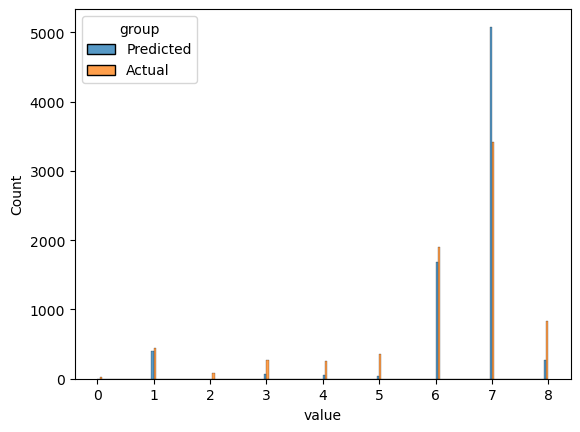

In [504]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# plot_df = pd.DataFrame({'value': list(xg_hard.predict(on_test=True)) + list(xg_hard.y_test), 'group': ['Predicted'] * len(xg_hard.predict(on_test=True)) + ['Actual'] * len(xg_hard.y_test)})
# sns.histplot(plot_df, x='value', hue='group', multiple='dodge')
# plt.savefig('../figures/hardness_score_pred_vs_actual_distribution.png')


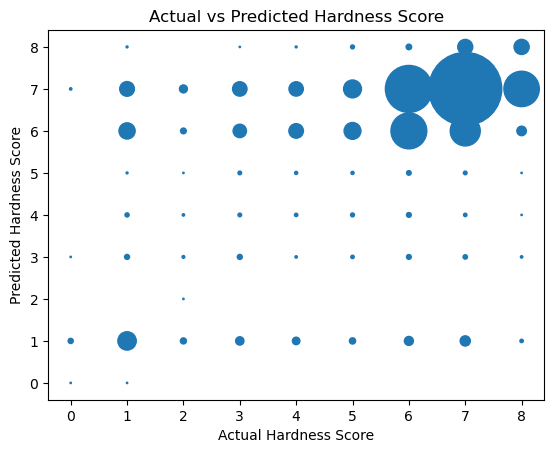

In [ ]:
# x = list(xg_hard.y_test)
# y = list(xg_hard.predict(on_test=True))
# u, c = np.unique(np.c_[x,y], return_counts=True, axis=0)
# s = lambda x : (((x-x.min())/float(x.max()-x.min())+1)*8)**2
# plt.scatter(u[:,0], u[:,1], s=c)
# plt.xlabel('Actual Hardness Score')
# plt.ylabel('Predicted Hardness Score')
# plt.title('Actual vs Predicted Hardness Score')
# plt.savefig('../figures/actual_vs_predicted_hardness_score_bubble_plot.png')

In [472]:
# Code credit in this cell to this notebook: https://colab.research.google.com/drive/1J2Wf7sxc9SVmGnSX_lImhT246pxNVZip?usp=sharing#scrollTo=hytEb0aXfcwm
elos = models.compute_elo(train_df_kmeans)
bootstrap_elo_lu = models.get_bootstrap_result(train_df_kmeans, models.compute_elo, 1000)
bootstrap_lu_median = bootstrap_elo_lu.median().reset_index().set_axis(["model", "Elo rating"], axis=1)
bootstrap_lu_median["Elo rating"] = (bootstrap_lu_median["Elo rating"] + 0.5).astype(int)
elo_dict = dict(zip(bootstrap_lu_median.model, bootstrap_lu_median["Elo rating"]))

In [473]:
# appending difference in elo rating as a feature to train dataframe
train_df_kmeans['elo_diff'] =  train_df_kmeans['model_a'].apply(lambda x: elo_dict[x]) - train_df_kmeans['model_b'].apply(lambda x: elo_dict[x])
test_df_kmeans['elo_diff'] =  test_df_kmeans['model_a'].apply(lambda x: elo_dict[x]) - test_df_kmeans['model_b'].apply(lambda x: elo_dict[x])

In [509]:
# train xgboost model
xgboost_model = models.XGBoostModel(train_df_kmeans, test_df_kmeans)
xgboost_model.preprocess(features=['elo_diff', 'prompt_clusters_1', 'prompt_clusters_2', 'prompt_clusters_3', 'prompt_clusters_4', 'prompt_clusters_5', 'prompt_clusters_6', 'prompt_clusters_7', 'prompt_clusters_8', 'prompt_clusters_9'])
# xgboost_model.preprocess(features=features_list['all_kmeans'])
xgboost_model.train_model()
xgboost_pred = xgboost_model.predict()
xgboost_model.evaluate(xgboost_pred)
# winners_pred = xgboost_model.predict(on_test=True)
# xgboost_model.evaluate(winners_pred, on_test=True)
winners_pred = xgboost_model.predict_to_outcome(xgboost_model.predict(on_test=True))

The accuracy is:  0.5511948093052699
Classification report:                precision    recall  f1-score   support

           0       0.56      0.74      0.64      8998
           1       0.56      0.72      0.63      8852
           2       0.47      0.03      0.05      2791
           3       0.45      0.17      0.25      4635

    accuracy                           0.55     25276
   macro avg       0.51      0.42      0.39     25276
weighted avg       0.53      0.55      0.50     25276



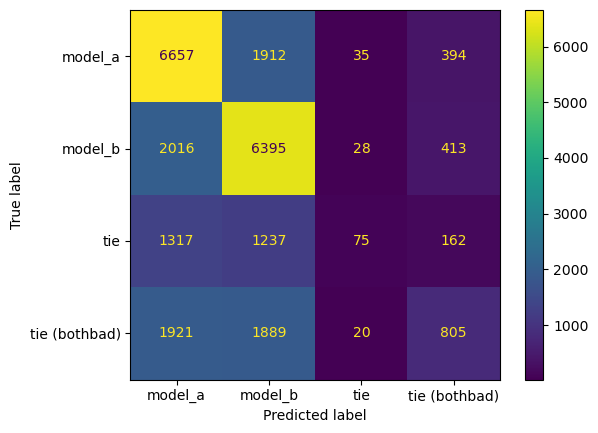

In [ ]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# cm = confusion_matrix(xgboost_model.y_train, xgboost_model.predict())
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['model_a', 'model_b', 'tie', 'tie (bothbad)'])
# disp.plot()

# plt.savefig('../figures/xgboost_winners_confusion_matrix.png')

In [456]:
# create submission file
pd.concat([test_df_kmeans['question_id'], pd.Series(winners_pred, name='winner'), pd.Series(xg_hard_pred, name='hardness_score')], axis=1).to_csv('predictions.csv', index=False)